Epoch 1/100
12/12 [==============================] - 10s 587ms/step - loss: 0.5743 - accuracy: 0.6898 - val_loss: 0.4817 - val_accuracy: 0.7447
Epoch 2/100
12/12 [==============================] - 10s 808ms/step - loss: 0.0900 - accuracy: 0.9786 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/100
12/12 [==============================] - 6s 533ms/step - loss: 3.1164e-04 - accuracy: 1.0000 - val_loss: 8.9139e-06 - val_accuracy: 1.0000
Epoch 4/100
12/12 [==============================] - 9s 787ms/step - loss: 5.0293e-06 - accuracy: 1.0000 - val_loss: 4.1769e-06 - val_accuracy: 1.0000
Epoch 5/100
12/12 [==============================] - 7s 543ms/step - loss: 2.8607e-06 - accuracy: 1.0000 - val_loss: 3.0963e-06 - val_accuracy: 1.0000
Epoch 6/100
12/12 [==============================] - 8s 681ms/step - loss: 2.2064e-06 - accuracy: 1.0000 - val_loss: 2.4929e-06 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 7s 542ms/step - loss: 1.8005e-06 - accuracy: 1.0000 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 139ms/step - loss: 6.1354e-08 - accuracy: 1.0000
RCNN Test Loss: 6.135418573194329e-08
RCNN Test Accuracy: 1.0
3/3 [==============================] - 1s 146ms/step
RCNN Accuracy: 1.0
RCNN Confusion Matrix:
 [[45  0]
 [ 0 49]]
RCNN Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        45
         1.0       1.00      1.00      1.00        49

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94



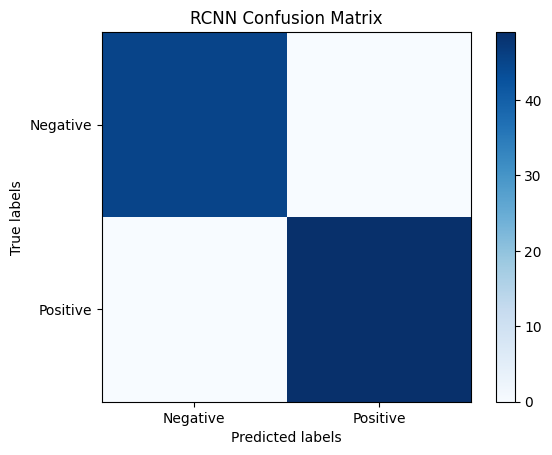

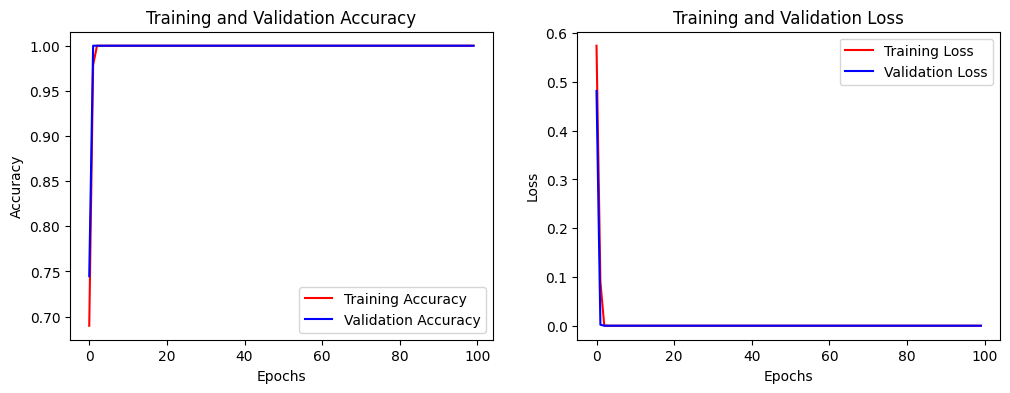

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers, models
import pandas as pd
import time

# Load data from positive and negative directories
def load_data_from_directories(pos_directory, neg_directory, img_size=(100, 100)):
    positive_images = []
    negative_images = []

    # Load positive images
    for filename in os.listdir(pos_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(pos_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image
            positive_images.append(img)

    # Load negative images
    for filename in os.listdir(neg_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(neg_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image
            negative_images.append(img)

    return np.array(positive_images), np.array(negative_images)

# Directories containing positive and negative images
positive_directory = '/content/drive/MyDrive/positive training'
negative_directory = '/content/drive/MyDrive/negative training'

# Load data
positive_images, negative_images = load_data_from_directories(positive_directory, negative_directory)

# Create labels
positive_labels = np.ones(len(positive_images))
negative_labels = np.zeros(len(negative_images))

# Combine images and labels
X = np.concatenate((positive_images, negative_images), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)

# Normalize pixel values
X = X / 255.0

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RCNN model
def create_rcnn_model(input_shape):
    model = models.Sequential()
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten before passing to LSTM
    model.add(layers.TimeDistributed(layers.Flatten()))

    # Recurrent layers
    model.add(layers.LSTM(64, return_sequences=True))  # LSTM layer with return sequences
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Create RCNN model
input_shape = X_train[0].shape
rcnn_model = create_rcnn_model(input_shape)

# Compile the RCNN model
rcnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RCNN model and store history
rcnn_history = rcnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Save training history to CSV
history_df = pd.DataFrame(rcnn_history.history)
history_df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)

# Save the model
rcnn_model.save('/content/drive/MyDrive/rcnn_model.h5')

# Evaluate the RCNN model
rcnn_test_loss, rcnn_test_accuracy = rcnn_model.evaluate(X_test, y_test)

print("RCNN Test Loss:", rcnn_test_loss)
print("RCNN Test Accuracy:", rcnn_test_accuracy)

# Generate predictions
rcnn_y_pred_probs = rcnn_model.predict(X_test)
rcnn_y_pred = (rcnn_y_pred_probs > 0.5).astype(int)

# Calculate accuracy
rcnn_accuracy = accuracy_score(y_test, rcnn_y_pred)
print("RCNN Accuracy:", rcnn_accuracy)

# Calculate confusion matrix
rcnn_confusion_mat = confusion_matrix(y_test, rcnn_y_pred)
print("RCNN Confusion Matrix:\n", rcnn_confusion_mat)

# Generate classification report
rcnn_class_report = classification_report(y_test, rcnn_y_pred)
print("RCNN Classification Report:\n", rcnn_class_report)

# Plot confusion matrix
plt.imshow(rcnn_confusion_mat, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.title('RCNN Confusion Matrix')
plt.show()

# Plot training & validation loss and accuracy
def plot_training_history(history_df):
    # Extract the data from the history DataFrame
    acc = history_df['accuracy']
    val_acc = history_df['val_accuracy']
    loss = history_df['loss']
    val_loss = history_df['val_loss']

    epochs = range(len(acc))

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_df)



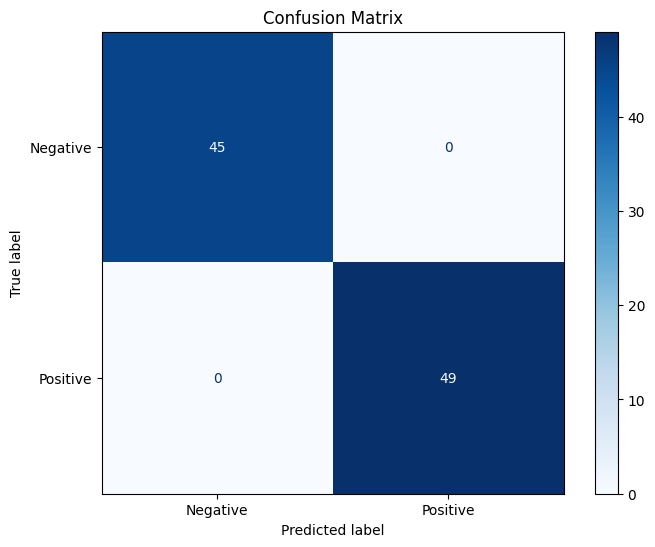

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Define the confusion matrix
confusion_matrix = np.array([[45, 0], [0, 49]])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive'])

# Display the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the model
model_save_path = '/content/drive/MyDrive/rcnn_model.h5'
rcnn_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/rcnn_model.h5


In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model(model_save_path)
print("Model loaded successfully.")


Model loaded successfully.


In [ ]:
import time

def classify_image(model, image_path, input_shape):
    img = cv2.imread(image_path)
    img = cv2.resize(img, input_shape[:2])  # Resize image to match input shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values

    start_time = time.time()
    prediction = model.predict(img)
    end_time = time.time()

    prediction_time = end_time - start_time
    label = 'Positive' if prediction > 0.5 else 'Negative'
    return label, img[0], prediction_time

# Function to display image with label inside
def display_image_with_label_inside(image, label):
    # Convert image to uint8 format
    image_uint8 = (image * 255).astype(np.uint8)

    # Convert image to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB)

    # Draw label text inside the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.4  # Adjust font size
    color = (255, 0, 0) if label == 'Positive' else (0, 0, 255)  # Red for Positive, Blue for Negative
    thickness = 1  # Adjust font thickness
    position = (10, 30)  # Position for the label
    cv2.putText(image_rgb, label, position, font, font_scale, color, thickness, cv2.LINE_AA)

    # Display the image with label inside
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
